In [1]:
import numpy as np
import pandas as pd
import os
from util import read_json_from, write_json_to
from data import proteomeHD_df
from visualization_util import df_roc_analysis,df_precision_recall_analysis
from validation import validate_relations_in_df,full_report_calculation_by_size,simplifed_report_df,is_corum_verifiable
import networkx as nx
PATH_ROOT = os.getcwd().replace("\\","/").replace("/notebooks","")

# ProteomeHD: knn ensemble

In [2]:
prohd_ratios_min95_path = f"{PATH_ROOT}/data_sources/ProteomeHD/prohd_ratios_min95.csv"
prohd_ratios_min95_df = pd.read_csv(prohd_ratios_min95_path)
prohd_ratios_min95_df_simplified_id = prohd_ratios_min95_df['Simplified_protein_ID'].to_numpy()
prohd_ratios_min95_df_feature_matrix = prohd_ratios_min95_df.iloc[:,2:].fillna(0).to_numpy()
prohd_ratios_min95_df_lookup = {prohd_ratios_min95_df_simplified_id[i]:i for i in range(len(prohd_ratios_min95_df_simplified_id))}

In [3]:
from knn_ensemble import generate_link_candidates,convert_prediction_to_df
NEIGHBOR_SIZE = 20
CHUNK_SIZE = 5
SAMPLE_SIZE = 100
CANDIDATE_SIZE = 5012

In [4]:
%time proteomeHD_chunked_candidates = np.array(list(map(lambda x: generate_link_candidates(x,prohd_ratios_min95_df_simplified_id,prohd_ratios_min95_df_feature_matrix,prohd_ratios_min95_df_lookup,NEIGHBOR_SIZE,CHUNK_SIZE,SAMPLE_SIZE,CANDIDATE_SIZE,True),prohd_ratios_min95_df_simplified_id)))

Wall time: 4min 9s


In [5]:
proteomeHD_pred_df = convert_prediction_to_df(prohd_ratios_min95_df_simplified_id,proteomeHD_chunked_candidates[:,0],proteomeHD_chunked_candidates[:,1])

In [7]:
proteomeHD_pred_df_filtered = proteomeHD_pred_df[proteomeHD_pred_df['appearance'] >= 6]
proteomeHD_pred_df_filtered

,protein_1,protein_2,appearance
0,A0AV96,Q96LA8,11.0
1,A0AV96,P29373,9.0
2,A0AV96,O14975,7.0
3,A0AV96,Q8NI60,6.0
4,A0AV96,Q9Y365,6.0
...,...,...,...
6740060,Q9Y6Y0,Q6DKJ4,6.0
6740061,Q9Y6Y0,O94919,6.0
6740062,Q9Y6Y0,O60220,6.0
6741446,Q9Y6Y8,O43399,6.0


In [8]:
proteomeHD_pred_df_filtered_validated = validate_relations_in_df(proteomeHD_pred_df_filtered)
proteomeHD_pred_df_filtered_validated

,protein_1,protein_2,appearance,binary_interaction,cocomplex
0,A0AV96,Q96LA8,11.0,0,0
1,A0AV96,P29373,9.0,0,0
2,A0AV96,O14975,7.0,0,0
3,A0AV96,Q8NI60,6.0,0,0
4,A0AV96,Q9Y365,6.0,0,0
...,...,...,...,...,...
6740060,Q9Y6Y0,Q6DKJ4,6.0,0,0
6740061,Q9Y6Y0,O94919,6.0,0,0
6740062,Q9Y6Y0,O60220,6.0,0,0
6741446,Q9Y6Y8,O43399,6.0,0,0


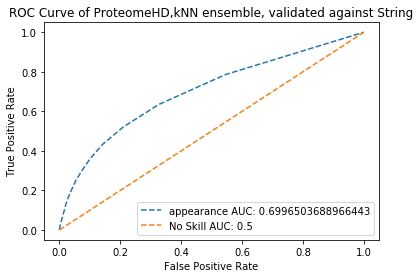

In [9]:
df_roc_analysis(proteomeHD_pred_df_filtered_validated,['appearance'],'binary_interaction','ProteomeHD,kNN ensemble','String')

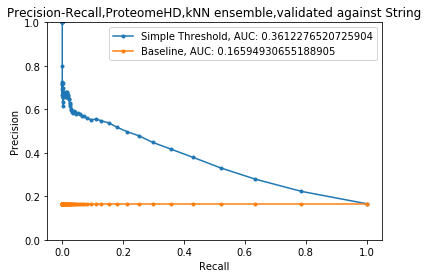

In [10]:
df_precision_recall_analysis(proteomeHD_pred_df_filtered_validated['binary_interaction'].to_numpy(),
                             proteomeHD_pred_df_filtered_validated['appearance'].to_numpy(),
                             'Simple Threshold',
                             'Precision-Recall,ProteomeHD,kNN ensemble,validated against String',
                             ylim=(0,1)
                            )

## Using Coregulating pairs (as result of treeClust) 

In [11]:
coreg_df = pd.read_csv(f"{PATH_ROOT}/data_sources/ProteomeHD/top_coregulation_scores_simplified.csv")
coreg_df

,Majority_protein_ID_1,Majority_protein_ID_2,protein_1,protein_2,coregulation_score
0,P62280,P62269,P62280,P62269,0.375848
1,P61160;P61160-2,P61158,P61160,P61158,0.375144
2,P61158,O15145,P61158,O15145,0.373689
3,P62269,P62081,P62269,P62081,0.370688
4,P62269,P46777,P62269,P46777,0.368026
...,...,...,...,...,...
62807,Q9UKX7-2,Q8WXA9-2;Q8WXA9,Q9UKX7,Q8WXA9,0.020004
62808,Q16630-2;Q16630;Q16630-3,O43818,Q16630,O43818,0.020004
62809,Q9UBD5-2,Q75QN2;Q75QN2-2,Q9UBD5,Q75QN2,0.020004
62810,Q9Y3Y2-4;Q9Y3Y2;Q9Y3Y2-3,P63220,Q9Y3Y2,P63220,0.020004


In [12]:
coreg_pred_df = validate_relations_in_df(coreg_df)
coreg_pred_df

,Majority_protein_ID_1,Majority_protein_ID_2,protein_1,protein_2,coregulation_score,binary_interaction,cocomplex
0,P62280,P62269,P62280,P62269,0.375848,1,1
1,P61160;P61160-2,P61158,P61160,P61158,0.375144,1,1
2,P61158,O15145,P61158,O15145,0.373689,1,1
3,P62269,P62081,P62269,P62081,0.370688,0,1
4,P62269,P46777,P62269,P46777,0.368026,1,1
...,...,...,...,...,...,...,...
62807,Q9UKX7-2,Q8WXA9-2;Q8WXA9,Q9UKX7,Q8WXA9,0.020004,0,0
62808,Q16630-2;Q16630;Q16630-3,O43818,Q16630,O43818,0.020004,0,0
62809,Q9UBD5-2,Q75QN2;Q75QN2-2,Q9UBD5,Q75QN2,0.020004,0,0
62810,Q9Y3Y2-4;Q9Y3Y2;Q9Y3Y2-3,P63220,Q9Y3Y2,P63220,0.020004,0,0


In [33]:
np.sum(coreg_pred_df['binary_interaction'].to_numpy())

10355

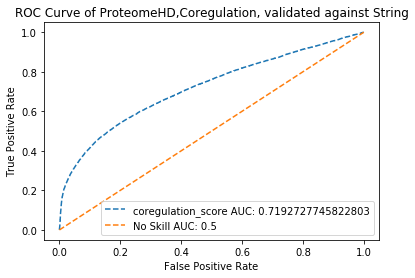

In [13]:
df_roc_analysis(coreg_pred_df,['coregulation_score'],'binary_interaction','ProteomeHD,Coregulation','String')

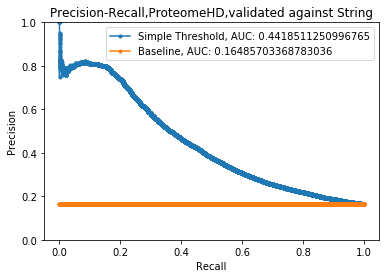

In [14]:
df_precision_recall_analysis(coreg_pred_df['binary_interaction'].to_numpy(),
                             coreg_pred_df['coregulation_score'].to_numpy(),
                             'Simple Threshold',
                             'Precision-Recall,ProteomeHD,validated against String',
                             ylim=(0,1)
                            )

In [151]:
# NEIGHBOR_SIZE = 20
# CHUNK_SIZE = 5
# SAMPLE_SIZE = 100
# CANDIDATE_SIZE = 5012
# %time a,b = generate_link_candidates("P62280",prohd_ratios_min95_df_simplified_id,prohd_ratios_min95_df_feature_matrix,prohd_ratios_min95_df_lookup,NEIGHBOR_SIZE,CHUNK_SIZE,SAMPLE_SIZE,CANDIDATE_SIZE,True)

Wall time: 182 ms


In [45]:
def generate_network_from_df(df,val='coregulation_score'):
    ppa_graph = nx.Graph()
    ppa_graph.clear()
    for idx,row in df.iterrows():
        protein1 = row['protein_1']
        protein2 = row['protein_2']
        appearance = int(row[val])
        ppa_graph.add_edge(protein1,protein2,appearance=appearance)
    return ppa_graph

In [46]:
proHD_coregulation_net = generate_network_from_df(coreg_pred_df)
proHD_coregulation_net_cliques = list(nx.find_cliques(proHD_coregulation_net))
proHD_coregulation_verifiable_cliques = list(filter(is_corum_verifiable,proHD_coregulation_net_cliques))
proHD_coregulation_non_verifiable_cliques = list(filter(lambda x: not is_corum_verifiable(x),proHD_coregulation_net_cliques))
print(f"Number of nodes: {len(proHD_coregulation_net.nodes)}")
print(f"Number of edges: {len(proHD_coregulation_net.edges)}")
print(f"Number of verifiable cliques: {len(proHD_coregulation_verifiable_cliques)}")
print(f"Number of unverifiable cliques: {len(proHD_coregulation_non_verifiable_cliques)}")

Number of nodes: 2743
Number of edges: 62313
Number of verifiable cliques: 483
Number of unverifiable cliques: 88974


In [49]:
nx.info(proHD_coregulation_net)

'Name: \nType: Graph\nNumber of nodes: 2743\nNumber of edges: 62313\nAverage degree:  45.4342'

In [7]:
full_report_dict = full_report_calculation_by_size(proHD_coregulation_verifiable_cliques)
simplified_report_df = simplifed_report_df(full_report_dict)
simplified_report_df = simplified_report_df.sort_values(by=['clique_size'])
simplified_report_df

,clique_size,hitting_cliques,total_cliques,precision,complex_hit
2,2,39,133,0.293233,98
4,3,7,57,0.122807,12
8,4,18,58,0.310345,9
1,5,14,34,0.411765,3
7,6,8,35,0.228571,2
0,7,6,32,0.187500,3
14,8,4,11,0.363636,2
11,9,2,12,0.166667,2
22,10,1,9,0.111111,2
12,11,0,2,0.000000,0


In [51]:
proHD_knn_ensemble_net = generate_network_from_df(proteomeHD_pred_df_filtered,'appearance')
proHD_knn_ensemble_net_cliques = list(nx.find_cliques(proHD_knn_ensemble_net))
proHD_knn_ensemble_verifiable_cliques = list(filter(is_corum_verifiable,proHD_knn_ensemble_net_cliques))
proHD_knn_ensemble_non_verifiable_cliques = list(filter(lambda x: not is_corum_verifiable(x),proHD_knn_ensemble_net_cliques))
print(f"Number of nodes: {len(proHD_knn_ensemble_net.nodes)}")
print(f"Number of edges: {len(proHD_knn_ensemble_net.edges)}")
print(f"Number of verifiable cliques: {len(proHD_knn_ensemble_verifiable_cliques)}")
print(f"Number of unverifiable cliques: {len(proHD_knn_ensemble_non_verifiable_cliques)}")

Number of nodes: 4960
Number of edges: 51944
Number of verifiable cliques: 33075
Number of unverifiable cliques: 40044


In [52]:
nx.info(proHD_knn_ensemble_net)

'Name: \nType: Graph\nNumber of nodes: 4960\nNumber of edges: 51944\nAverage degree:  20.9452'

In [16]:
full_report_dict = full_report_calculation_by_size(proHD_knn_ensemble_verifiable_cliques)
simplified_report_df = simplifed_report_df(full_report_dict)
simplified_report_df = simplified_report_df.sort_values(by=['clique_size'])
simplified_report_df

,clique_size,hitting_cliques,total_cliques,precision,complex_hit
0,2,152,1844,0.082430,256
8,3,154,1254,0.122807,80
2,4,168,986,0.170385,52
3,5,124,733,0.169168,22
4,6,62,580,0.106897,17
1,7,52,474,0.109705,9
6,8,56,418,0.133971,12
5,9,46,384,0.119792,6
7,10,50,205,0.243902,6
9,11,77,218,0.353211,5


## PQTL

## pQTL KNN Ensemble

In [21]:
from knn_ensemble import generate_link_candidates,convert_prediction_to_df
from data import pQTL_protein_df,pQTL_protein_ids,pQTL_protein_feature_matrix,pQTL_protein_idx_lookup
NEIGHBOR_SIZE = 20
CHUNK_SIZE = 5
SAMPLE_SIZE = 100
CANDIDATE_SIZE = 5012

In [22]:
%time pQTL_chunked_candidates = np.array(list(map(lambda x: generate_link_candidates(x,pQTL_protein_ids,pQTL_protein_feature_matrix,pQTL_protein_idx_lookup,NEIGHBOR_SIZE,CHUNK_SIZE,SAMPLE_SIZE,CANDIDATE_SIZE,True),pQTL_protein_ids)))

Wall time: 2min 21s


In [23]:
pQTL_pred_df = convert_prediction_to_df(pQTL_protein_ids,pQTL_chunked_candidates[:,0],pQTL_chunked_candidates[:,1])
pQTL_pred_df

,protein_1,protein_2,appearance
0,O60762,Q9P2X0,14.0
1,O60762,O95295,13.0
2,O60762,O60547,9.0
3,O60762,P21964,8.0
4,O60762,Q15907,8.0
...,...,...,...
4169042,P62987,O75436,1.0
4169043,P62987,Q9BRR9,1.0
4169044,P62987,Q9P2E3,1.0
4169045,P62987,Q29RF7,1.0


In [29]:
pQTL_pred_df_filtered = pQTL_pred_df[pQTL_pred_df['appearance'] >= 11]
pQTL_pred_df_filtered

,protein_1,protein_2,appearance
0,O60762,Q9P2X0,14.0
1,O60762,O95295,13.0
1172,Q8IZE3,Q16537,13.0
1173,Q8IZE3,Q96EK5,12.0
1174,Q8IZE3,Q15154,11.0
...,...,...,...
4168352,P62987,P61247,12.0
4168353,P62987,P62917,11.0
4168354,P62987,P62847,11.0
4168355,P62987,Q12906,11.0


In [30]:
pQTL_pred_df_filtered_validated = validate_relations_in_df(pQTL_pred_df_filtered)
pQTL_pred_df_filtered_validated

,protein_1,protein_2,appearance,binary_interaction,cocomplex
0,O60762,Q9P2X0,14.0,1,1
1,O60762,O95295,13.0,0,0
1172,Q8IZE3,Q16537,13.0,0,0
1173,Q8IZE3,Q96EK5,12.0,0,0
1174,Q8IZE3,Q15154,11.0,0,0
...,...,...,...,...,...
4168352,P62987,P61247,12.0,1,1
4168353,P62987,P62917,11.0,1,1
4168354,P62987,P62847,11.0,1,1
4168355,P62987,Q12906,11.0,0,0


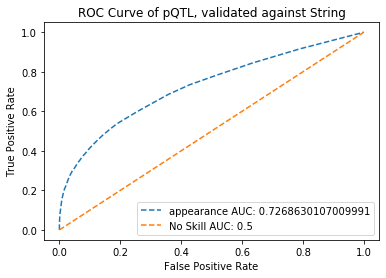

In [31]:
df_roc_analysis(pQTL_pred_df_filtered_validated,['appearance'],'binary_interaction','pQTL','String')

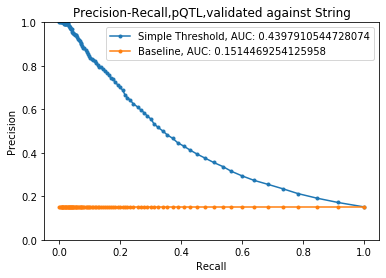

In [32]:
df_precision_recall_analysis(pQTL_pred_df_filtered_validated['binary_interaction'].to_numpy(),
                             pQTL_pred_df_filtered_validated['appearance'].to_numpy(),
                             'Simple Threshold',
                             'Precision-Recall,pQTL,validated against String',
                             ylim=(0,1)
                            )

## pQTL Using Coregulating Pairs

In [15]:
pQTL_top_coregulation_df = pd.read_csv(f"{PATH_ROOT}/data_sources/pQTL/pQTL_protein_top_coregulated_pairs.csv")
pQTL_top_coregulation_df

,protein_1,protein_2,coregulation_score
0,Q99643,Q96C36,0.697548
1,P35813,P0DPI2,0.697548
2,Q9BYC5,P54687,0.697548
3,Q96C36,P62834,0.697548
4,Q9H9B4,P36551,0.697548
...,...,...,...
46986,Q9BYT8,Q15185,0.492460
46987,Q8NBF2,Q15056,0.492457
46988,Q969U7,Q6P9B9,0.492449
46989,Q96AE4,Q969U7,0.492449


In [16]:
pQTL_top_coregulation_df_validated = validate_relations_in_df(pQTL_top_coregulation_df)
pQTL_top_coregulation_df_validated

,protein_1,protein_2,coregulation_score,binary_interaction,cocomplex
0,Q99643,Q96C36,0.697548,0,0
1,P35813,P0DPI2,0.697548,0,0
2,Q9BYC5,P54687,0.697548,0,0
3,Q96C36,P62834,0.697548,0,0
4,Q9H9B4,P36551,0.697548,0,0
...,...,...,...,...,...
46986,Q9BYT8,Q15185,0.492460,0,0
46987,Q8NBF2,Q15056,0.492457,0,0
46988,Q969U7,Q6P9B9,0.492449,0,0
46989,Q96AE4,Q969U7,0.492449,0,0


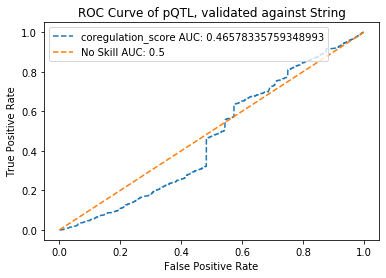

In [17]:
df_roc_analysis(pQTL_top_coregulation_df_validated,['coregulation_score'],'binary_interaction','pQTL','String')

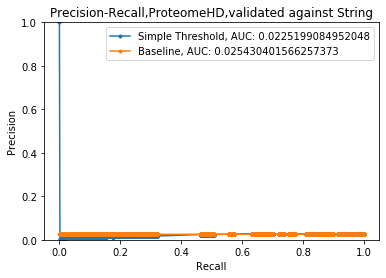

In [18]:
df_precision_recall_analysis(pQTL_top_coregulation_df_validated['binary_interaction'].to_numpy(),
                             pQTL_top_coregulation_df_validated['coregulation_score'].to_numpy(),
                             'Simple Threshold',
                             'Precision-Recall,ProteomeHD,validated against String',
                             ylim=(0,1)
                            )

In [88]:
simplified_coreg_pairs_df = pd.read_csv(f"{PATH_ROOT}/data_sources/ProteomeHD/coregulation_scores_simplified.csv")
simplified_coreg_pairs_df

,protein_1,protein_2,coregulation_score
0,A0AVT1,A0AV96,0.000500
1,A0FGR8,A0AV96,0.000018
2,A0FGR8,A0AVT1,0.000088
3,A0MZ66,A0AV96,0.000504
4,A0MZ66,A0AVT1,0.000172
...,...,...,...
12562573,Q9Y6Y8,Q9Y6X3,0.003967
12562574,Q9Y6Y8,Q9Y6X5,0.000031
12562575,Q9Y6Y8,Q9Y6X8,0.000649
12562576,Q9Y6Y8,Q9Y6X9,0.001141


In [95]:
simplified_coreg_pairs_df_validated_positives = pd.read_csv(f"{PATH_ROOT}/data_sources/ProteomeHD/proteomeHD_pairs_positives.csv")
simplified_coreg_pairs_df_validated_negatives = pd.read_csv(f"{PATH_ROOT}/data_sources/ProteomeHD/proteomeHD_pairs_negatives.csv")

In [115]:
def get_new_sampled_dataset(pos_amount,neg_amount):
    pos_rand = np.random.choice(len(simplified_coreg_pairs_df_validated_positives), pos_amount, replace=False)
    neg_rand = np.random.choice(len(simplified_coreg_pairs_df_validated_negatives), neg_amount, replace=False)
    pos_df = simplified_coreg_pairs_df_validated_positives.iloc[pos_rand,:]
    neg_df = simplified_coreg_pairs_df_validated_negatives.iloc[neg_rand,:]
    new_df = pd.concat([pos_df,neg_df])
    new_df = new_df.sample(frac=1).reset_index(drop=True)
    return new_df

In [116]:
evenly_sampled_df = get_new_sampled_dataset(2000,2000)
evenly_sampled_df

,protein_1,protein_2,coregulation_score,binary_interaction,cocomplex
0,Q15437,P61956,0.000684,1,0
1,Q13561,P62258,0.015555,1,0
2,Q96PV6,O75934,0.003657,0,0
3,P84085,P11172,0.001679,0,0
4,Q9NX63,P25705,0.000950,1,0
...,...,...,...,...,...
3995,Q7L576,Q13510,0.000027,1,0
3996,P00533,O00499,0.000103,1,0
3997,P62899,P62888,0.140603,1,1
3998,Q9UPR3,P46777,0.001619,1,0


In [60]:
def euclidean_dist(vec1,vec2):
    return np.linalg.norm(vec1-vec2)
def pearson_corr(vec1,vec2):
    return np.corrcoef(vec1,vec2)[0,1]
def generate_knn_interaction_score(protein1,protein2,name_vector,embedding,lookup,neighbor_size=5,chunk_size=5,sample_size=100,candidate_size=5,dist=euclidean_dist,return_all=False):
    protein1_neighbors,protein1_neighbor_counts = generate_link_candidates(protein1,name_vector,embedding,lookup,neighbor_size,chunk_size,sample_size,candidate_size,dist,return_all)
    protein2_neighbors,protein2_neighbor_counts = generate_link_candidates(protein2,name_vector,embedding,lookup,neighbor_size,chunk_size,sample_size,candidate_size,dist,return_all)
    score = 0
    if protein2 in protein1_neighbors:
        score += protein1_neighbor_counts[np.where(protein1_neighbors == protein2)][0]
    if protein1 in protein2_neighbors:
        score += protein2_neighbor_counts[np.where(protein2_neighbors == protein1)][0]
    return score/2

In [6]:
%time generate_knn_interaction_score('Q9P2X0','O60762',prohd_ratios_min95_df_simplified_id,prohd_ratios_min95_df_feature_matrix,prohd_ratios_min95_df_lookup,NEIGHBOR_SIZE,CHUNK_SIZE,SAMPLE_SIZE,CANDIDATE_SIZE,True)

Wall time: 146 ms


2.5

In [101]:
from knn_ensemble import generate_link_candidates,convert_prediction_to_df
NEIGHBOR_SIZE = 500
CHUNK_SIZE = 5
SAMPLE_SIZE = 100
CANDIDATE_SIZE = 5012

In [11]:
def single_neighbor_run(configs,result_list=[]):
    for conf_idx,config in enumerate(configs):
        print(f"Running config: {config}")
        knn_ensemble_scores = []
        for idx,row in combined_mimi_proteomeHD.iterrows():
            knn_ensemble_scores.append(generate_knn_interaction_score(row['protein_1'],row['protein_2'],prohd_ratios_min95_df_simplified_id,prohd_ratios_min95_df_feature_matrix,prohd_ratios_min95_df_lookup,NEIGHBOR_SIZE,CHUNK_SIZE,SAMPLE_SIZE,CANDIDATE_SIZE,True))
        combined_mimi_proteomeHD['knn_ensemble_score'] = knn_ensemble_scores
        roc_auc = df_roc_analysis(combined_mimi_proteomeHD,['coregulation_score','knn_ensemble_score'],'binary_interaction','ProteomeHD','String',auc_only=True)[1]
        prc_auc = df_precision_recall_analysis(combined_mimi_proteomeHD['binary_interaction'].to_numpy(),
                                 combined_mimi_proteomeHD['knn_ensemble_score'].to_numpy(),
                                 'Simple Threshold',
                                 'Precision-Recall,ProteomeHD,validated against String',
                                 ylim=(0,1),
                                 auc_only=True
                                )
        print(roc_auc)
        print(prc_auc)
        single_run_report = {
            'neighbor': 500,
            'chunk_size': 5,
            'sample_size': 100,
            'candidate_size': 5012,
            'result': {
                'treeclust': {
                    'auroc': 0.7328,
                    'auprc': 0.7646
                },
                'knn_ensemble': {
                    'auroc': roc_auc,
                    'auprc': prc_auc
                }
            }
        }
        result_list.append(single_run_report)
    return result_list

Running config: 1000
0.7092514999999999
0.7320814787290129


[{'neighbor': 20,
  'chunk_size': 5,
  'sample_size': 100,
  'candidate_size': 5012,
  'result': {'treeclust': {'auroc': 0.7328, 'auprc': 0.7646},
   'knn_ensemble': {'auroc': 0.6425339999999999,
    'auprc': 0.6875016307593345}}},
 {'neighbor': 40,
  'chunk_size': 5,
  'sample_size': 100,
  'candidate_size': 5012,
  'result': {'treeclust': {'auroc': 0.7328, 'auprc': 0.7646},
   'knn_ensemble': {'auroc': 0.6827255, 'auprc': 0.7175228061536759}}},
 {'neighbor': 60,
  'chunk_size': 5,
  'sample_size': 100,
  'candidate_size': 5012,
  'result': {'treeclust': {'auroc': 0.7328, 'auprc': 0.7646},
   'knn_ensemble': {'auroc': 0.6782685, 'auprc': 0.7134762056148232}}},
 {'neighbor': 80,
  'chunk_size': 5,
  'sample_size': 100,
  'candidate_size': 5012,
  'result': {'treeclust': {'auroc': 0.7328, 'auprc': 0.7646},
   'knn_ensemble': {'auroc': 0.6854849999999999,
    'auprc': 0.7187351119653567}}},
 {'neighbor': 100,
  'chunk_size': 5,
  'sample_size': 100,
  'candidate_size': 5012,
  'result': 

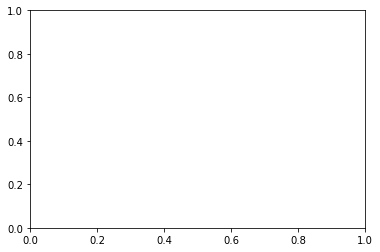

In [17]:
report_list = single_neighbor_run(range(1000,1001,20),report_list)
report_list

In [15]:
write_json_to(report_list,f"{PATH_ROOT}/data_sources/ProteomeHD/proteomeHD_knn_ensemble_report.json")

In [117]:
%load_ext autoreload
%autoreload 2
knn_ensemble_scores = []
for idx,row in combined_mimi_proteomeHD.iterrows():
    knn_ensemble_scores.append(generate_knn_interaction_score(row['protein_1'],row['protein_2'],prohd_ratios_min95_df_simplified_id,prohd_ratios_min95_df_feature_matrix,prohd_ratios_min95_df_lookup,NEIGHBOR_SIZE,CHUNK_SIZE,SAMPLE_SIZE,CANDIDATE_SIZE,euclidean_dist,True))
    if idx % 100 == 1:
        print(idx)
combined_mimi_proteomeHD['knn_ensemble_score'] = knn_ensemble_scores

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1
101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401
1501
1601
1701
1801
1901


In [122]:
combined_mimi_proteomeHD

,protein_1,protein_2,coregulation_score,binary_interaction,cocomplex,knn_ensemble_score,abs_diff
0,P49207,P25398,0.205659,1,1,54.5,54.294341
1,P60953,P49792,0.000214,1,0,14.0,13.999786
2,P28070,P06493,0.000017,1,0,3.5,3.499983
3,Q9C0J8,Q8NFH5,0.006748,1,0,32.5,32.493252
4,Q9BVI4,Q92979,0.027419,1,0,34.5,34.472581
...,...,...,...,...,...,...,...
1995,Q9Y605,Q6P4R8,0.000541,0,0,18.5,18.499459
1996,P67870,P30837,0.000359,0,0,9.0,8.999641
1997,Q96AT9,O15400,0.000471,0,0,9.5,9.499529
1998,Q96C23,Q06323,0.000123,0,0,7.0,6.999877


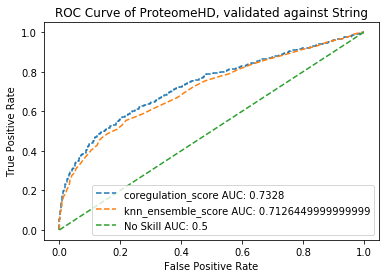

[0.7328, 0.7126449999999999, 0.5]

In [120]:
df_roc_analysis(combined_mimi_proteomeHD,['coregulation_score','knn_ensemble_score'],'binary_interaction','ProteomeHD','String')

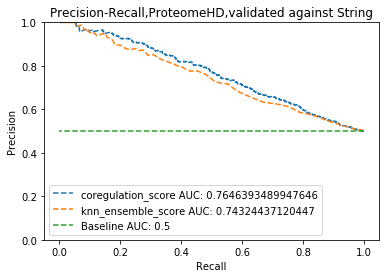

[0.7646393489947646, 0.74324437120447, 0.5]

In [121]:
df_precision_recall_analysis(combined_mimi_proteomeHD,['coregulation_score','knn_ensemble_score'],
                             'binary_interaction',
                            'Precision-Recall,ProteomeHD,validated against String',
                            ylim=(0,1))

In [24]:
single_run_config = {
    'neighbor': 500,
    'chunk_size': 5,
    'sample_size': 200,
    'candidate_size': 5012,
    'result': {
        'treeclust': {
            'auroc': 0.7328,
            'auprc': 0.7646
        },
        'knn_ensemble': {
            'auroc': 0.7166,
            'auprc': 0.7436
        }
    }
}

In [ ]:
## Simple logistic that takes in two features

In [136]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
min_max_scaler = preprocessing.MinMaxScaler()
features = combined_mimi_proteomeHD[['coregulation_score','knn_ensemble_score']].to_numpy()
labels = combined_mimi_proteomeHD[['binary_interaction']].to_numpy()
features_scaled = min_max_scaler.fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.9, random_state=42)
logistic_clf = LogisticRegression(random_state=0).fit(X_train, y_train)
logistic_clf_prob_score = logistic_clf.predict_proba(features)
# logistic_clf.score(X_test,y_test)
# svc_clf = LinearSVC(random_state=0)
# svc_clf.fit(X_train, y_train)
# svc_clf.score(X_test,y_test)

C:\Users\hoyin\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [142]:
combined_mimi_proteomeHD['logistic_score'] = logistic_clf_prob_score[:,1]

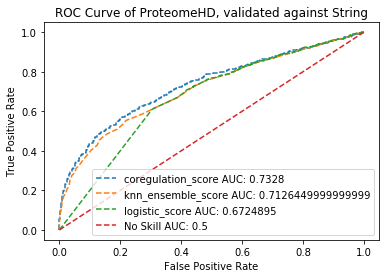

[0.7328, 0.7126449999999999, 0.6724895, 0.5]

In [143]:
df_roc_analysis(combined_mimi_proteomeHD,['coregulation_score','knn_ensemble_score','logistic_score'],'binary_interaction','ProteomeHD','String')

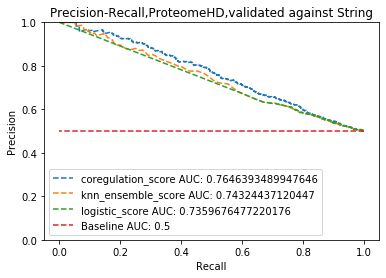

[0.7646393489947646, 0.74324437120447, 0.7359676477220176, 0.5]

In [144]:
df_precision_recall_analysis(combined_mimi_proteomeHD,['coregulation_score','knn_ensemble_score','logistic_score'],
                             'binary_interaction',
                            'Precision-Recall,ProteomeHD,validated against String',
                            ylim=(0,1))